In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
def nuke_Epa(x):
    if (abs(x) <= 1):
        return 3/4 * (1-x**2)
    else:
        return 0
    
def nuke_Epa_der(x):
    if (abs(x) <= 1):
        return (-3*x)/2
    else:
        return 0
    
def h_estimate_opt(X_pred, x_train, y_train, par_blur, nuke_der):
    def find_borders(x, some_x, par_blur):
        # x - точки диапазона переменной обучающей выборки
        # some_x - точка, значение в которой нужно предсказать
        # par_blur - параметр размытости
        # border_index -  индекс правой границы
        border_index = len(x)-1
        border_value = some_x + 30*par_blur
        for i in range(len(x)):
            if ( x.iloc[i] > border_value ):
                return i
        return border_index
    
    border_index = find_borders(x_train, X_pred, par_blur)
    x_train = x_train[0:border_index]
    y_train = y_train[0:border_index]
    c = 0
    size = len(x_train)
    T = x_train.iloc[-1] - x_train.iloc[0]
    z = T / (size * (par_blur**2))
    for i in range(size):
        c += y_train.iloc[i] * nuke_der((X_pred-x_train.iloc[i])/par_blur)
    return z * c

def u_one(x):
    if (x>=0):
        return 1
    else: return 0

In [4]:
def normal_DE( x, y ):  # правая часть дифура в нормальной форме y'=f(x,y)
    return - y + u_one(x)

In [5]:
# находим решение с шагом h с начальными условиями y(x0)=y0
# x - конец отрезка
def rungeKutta(x0, y0, x, h, DE):
    # Count number of iterations using step size or
    # step height h
    n = (int)((x - x0)/h) 
    # Iterate for number of iterations
    y = y0
    approx = []
    for i in range(1, n + 1):
        "Apply Runge Kutta Formulas to find next value of y"
        k1 = h * DE(x0, y)
        k2 = h * DE(x0 + 0.5 * h, y + 0.5 * k1)
        k3 = h * DE(x0 + 0.5 * h, y + 0.5 * k2)
        k4 = h * DE(x0 + h, y + k3)
 
        # Update next value of y
        y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
        approx.append( [ x0 , y ] )
        # Update next value of x
        x0 = x0 + h
    return approx


  0%|          | 0/233 [00:00<?, ?it/s]

100%|██████████| 233/233 [00:00<00:00, 235.64it/s]


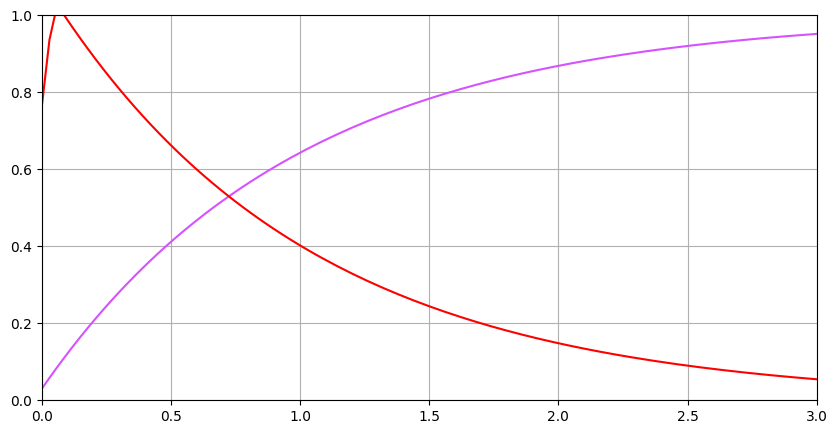

In [6]:
T = 7
period = 10
dispersion = 0.05
random_state = 10

# Driver method
x0 = 0
y0 = 0
x_end = 5
h = 0.03

approx_runge = rungeKutta(x0, y0, T, h, normal_DE)
approx_runge = np.array(approx_runge)

size = np.shape(approx_runge[:,0])[0]
data_sample = pd.DataFrame()
# делаем выборку с заданным периодом из всех точек что есть
#добавляем шум к данным
np.random.seed(random_state)
data_sample['t'] = approx_runge[:,0]
data_sample['obj1_one'] = approx_runge[:,1]


h = []
blur = 0.1
for i in tqdm(range(size)):
    h.append( h_estimate_opt(data_sample['t'].iloc[i], data_sample['t'], data_sample['obj1_one'], blur, nuke_Epa_der) )

data_sample['h_estimate'] = h

fig = plt.figure(figsize =(10, 5))
ax = plt.axes()

ax.plot(data_sample['t'], data_sample['obj1_one'],c='#D752FF')
ax.plot(data_sample['t'], data_sample['h_estimate'],c='red')


ax.set_xlim(0,3)
ax.set_ylim(0,1)
#plt.legend()
plt.grid()
plt.show()

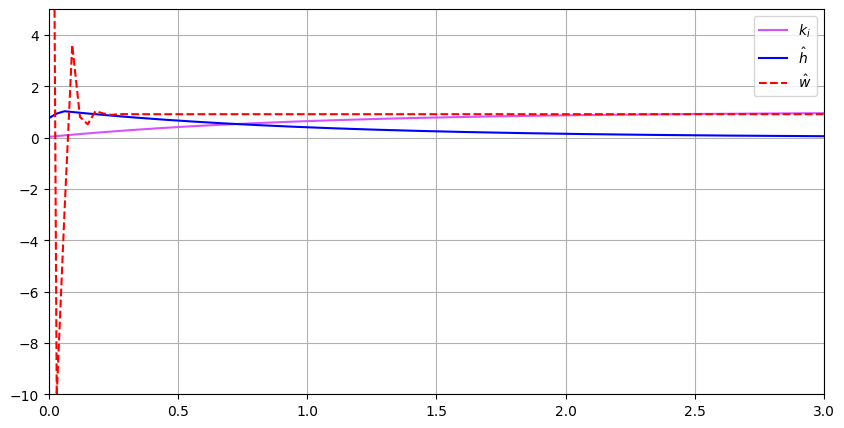

In [7]:
dt = data_sample['t'].iloc[2] - data_sample['t'].iloc[1]
size = len(data_sample['h_estimate'])
w = np.zeros(size)
w[0] = 1 / (data_sample['h_estimate'].iloc[0] * dt)
for i in range(1,size):
    #print(f'{i=}')
    temp_w = np.array([])
    if i == 1:
        temp_w = np.append(temp_w,data_sample['h_estimate'][1] * w[0])
    else:
        for j in range(i):
            temp_w = np.append(temp_w,data_sample['h_estimate'][i-j] * w[j])
    g = np.sum(temp_w)
    eee = (1 - np.sum(temp_w) * dt) / (data_sample['h_estimate'].iloc[0] * dt)
    w[i] = (1 - np.sum(temp_w) * dt) / (data_sample['h_estimate'].iloc[0] * dt)

data_sample['w_estimate'] = w

fig = plt.figure(figsize =(10, 5))
ax = plt.axes()

ax.plot(data_sample['t'], data_sample['obj1_one'],c='#D752FF', label = '$k_i$')
ax.plot(data_sample['t'], data_sample['h_estimate'],c='blue', label = '$\hat{h}$')
ax.plot(data_sample['t'], data_sample['w_estimate'], '--', c='red', label = '$\hat{w}$')

ax.set_xlim(0,3)
# ax.set_ylim(-15,40)
ax.set_ylim(-10,5)
plt.legend()
plt.grid()
plt.show()

100%|██████████| 233/233 [00:00<00:00, 245.20it/s]


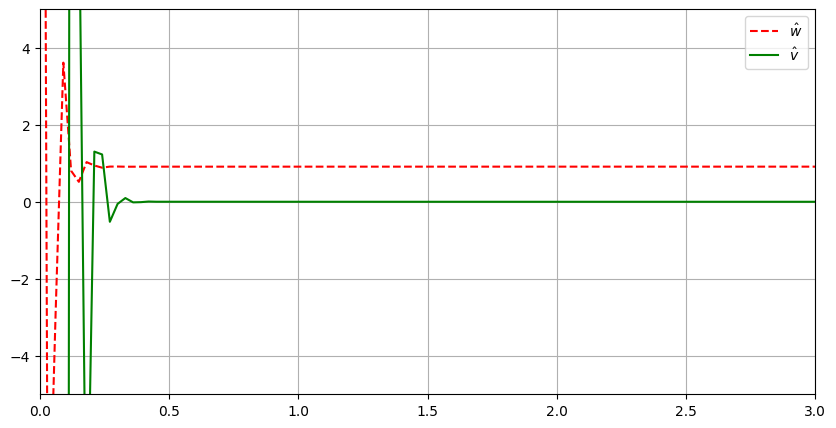

In [8]:
v = []
blur = 0.1
for i in tqdm(range(size)):
    v.append( h_estimate_opt(data_sample['t'].iloc[i], data_sample['t'], data_sample['w_estimate'], blur, nuke_Epa_der) )

data_sample['v_estimate'] = v

fig = plt.figure(figsize =(10, 5))
ax = plt.axes()

ax.plot(data_sample['t'], data_sample['w_estimate'], '--', c='red', label = '$\hat{w}$')
ax.plot(data_sample['t'], data_sample['v_estimate'], c='green', label = '$\hat{v}$')

ax.set_xlim(0,3)
ax.set_ylim(-5,5)
plt.legend()
plt.grid()
plt.show()

100%|██████████| 233/233 [00:00<00:00, 619.50it/s] 


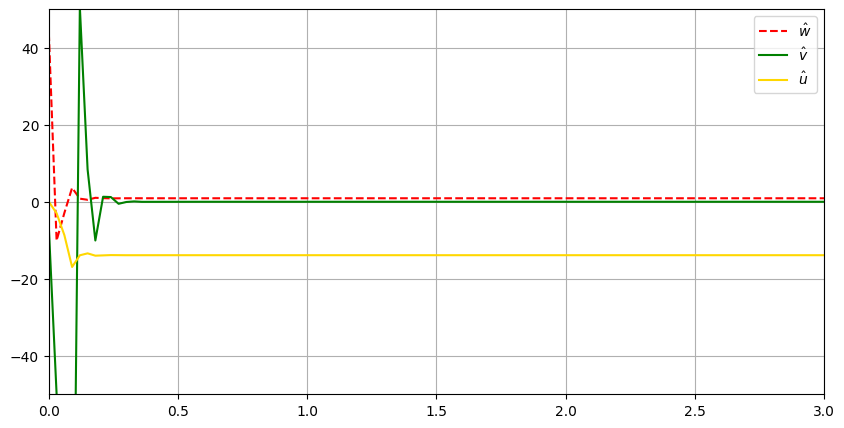

In [9]:
def x_want(t):
    return 2.

def u_proc(t_sample, k, v, dt):
    sum = 0
    for j in range(k):
        sum += v.iloc[k-j] * x_want(t_sample.iloc[j]) * dt
    return sum

u = []
blur = 0.1
for i in tqdm(range(size)):
    u.append( u_proc(data_sample['t'], i, data_sample['v_estimate'], dt) )

data_sample['u_conrol'] = u

fig = plt.figure(figsize =(10, 5))
ax = plt.axes()

ax.plot(data_sample['t'], data_sample['w_estimate'], '--', c='red', label = '$\hat{w}$')
ax.plot(data_sample['t'], data_sample['v_estimate'], c='green', label = '$\hat{v}$')
ax.plot(data_sample['t'], data_sample['u_conrol'], c='gold', label = '$\hat{u}$')
ax.set_xlim(0,3)
ax.set_ylim(-50,50)
plt.legend()
plt.grid()
plt.show()


In [10]:
def Nuke_regression(X_pred, x_train, y_train, par_blur, nuke):
    c = 0
    z = 0
    # print(f'{len(x_train)=}')
    # print(f'{par_blur=}')
    for i in range(len(x_train)):
        c += y_train[i]* ( nuke( (X_pred-x_train[i]) / par_blur) )
        z += ( nuke((X_pred-x_train[i])/par_blur) )
    return c/z

100%|██████████| 233/233 [00:00<00:00, 2840.88it/s]


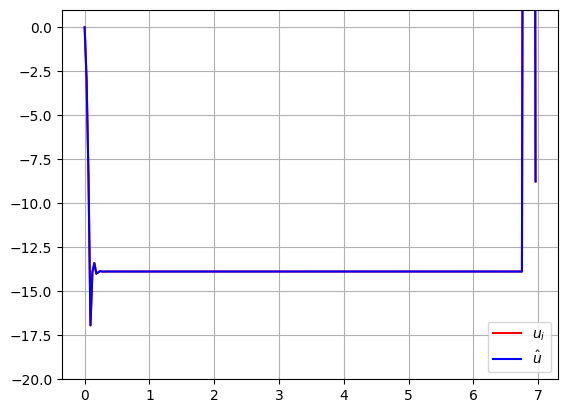

In [11]:
f_t = np.array(data_sample['t'])
f = u.copy()
u_glad = []
blur = 0.03
for i in tqdm(range(size)):
    u_glad.append( Nuke_regression(data_sample['t'].iloc[i], f_t, f, blur, nuke_Epa) )

plt.plot(f_t,u,color='red',label='$u_i$')
plt.plot(f_t,u_glad,color='blue',label='$\hat{u}$')
plt.legend()
plt.grid()
plt.ylim(-20,1)
plt.show()


In [12]:
def normal_DE_new( x, y ):  # правая часть дифура в нормальной форме y'=f(x,y)
    return - y + Nuke_regression(x, f_t, f, blur, nuke_Epa)

C:\Users\KoVaRu\AppData\Local\Temp\ipykernel_4952\1186166748.py:9: RuntimeWarning: invalid value encountered in double_scalars
  return c/z


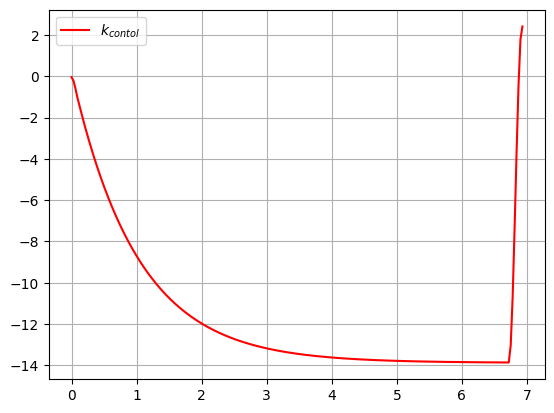

In [13]:
approx_runge = rungeKutta(x0, y0, T, 0.03, normal_DE_new)
approx_runge = np.array(approx_runge)

plt.plot(approx_runge[:,0],approx_runge[:,1],color='red',label='$k_{contol}$')
plt.legend()
plt.grid()
#plt.ylim(-20,1)
plt.show()